In [1]:
#Importing the required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from numpy import log
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

In [35]:
#Importing the data
data=pd.ExcelFile('Data.xlsx')
data.sheet_names

['Forecast 1', 'Sheet6', 'Monthly', 'Yearly', 'Quaterly']

In [36]:
#Selecting the sheet to work on
monthly=pd.read_excel(data, sheet_name='Monthly')
yearly=pd.read_excel(data, sheet_name='Yearly')
quaterly=pd.read_excel(data, sheet_name='Quaterly')
print(monthly.columns)
monthly.index=monthly['Month-Year']

Index(['Month', 'Year', 'Month-Year', 'A: Mini', 'A: Compact', 'A: Mid-Size',
       'B: Utility vehicles', 'C: Vans', 'Light Commercial Vehicles',
       'Sales to other OEM: A: Compact', 'Total Domestic', 'Total Export',
       'TotalSales(Domestic+Export)', 'Crude Oil (Barrel)', 'GDP',
       'Number of New cars by MS', 'Number of New cars by Top Competitors',
       'Maruti Suzuki's Market Share', 'Hyundai', 'Mahindra and Mahindra',
       'Tata', 'Honda', 'Toyota', 'Others', 'Dollar to Inr',
       'Average Parking Cost Delhi', 'Fuel Prices(Petrol)',
       'Fuel Prices(Diesel)', 'Advertising And promostion Budget',
       'Average Sales Cost of PV in India(∑(cost)*(number of units))/(Total number of units)'],
      dtype='object')


In [64]:
#Performing Logistic Regression
from sklearn.linear_model import LogisticRegression
X=monthly[['Crude Oil (Barrel)','GDP','Number of New cars by MS','Number of New cars by Top Competitors',"Maruti Suzuki's Market Share",'Dollar to Inr','Average Parking Cost Delhi']].iloc[:-8]
y=monthly['TotalSales(Domestic+Export)'].iloc[:-8]
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, y)
print(clf.predict(X[-8:]))
print(y[-8:])

[144981. 164369. 158189. 146766. 146766. 153539. 128338. 151721.]
Month-Year
2018-06-01    144981.0
2018-07-01    164369.0
2018-08-01    158189.0
2018-09-01    162290.0
2018-10-01    146766.0
2018-11-01    153539.0
2018-12-01    128338.0
2019-01-01    151721.0
Name: TotalSales(Domestic+Export), dtype: float64


C:\Users\PUSHKAR\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


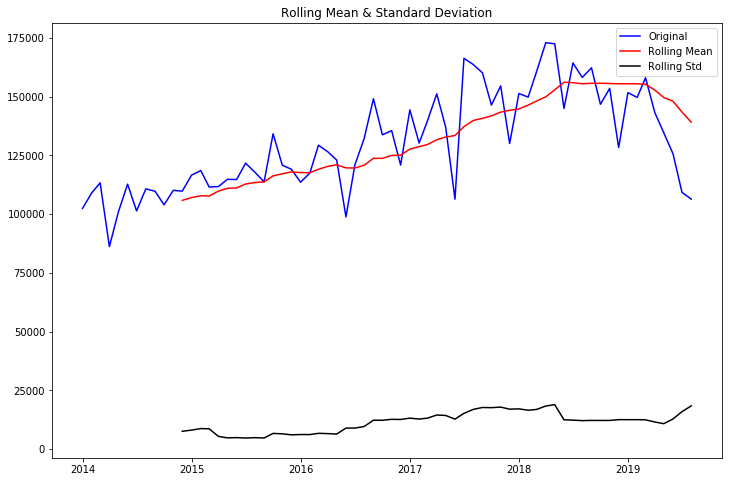

Results of Dickey-Fuller Test:
Test Statistic                 -1.581071
p-value                         0.493095
#Lags Used                      6.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


In [37]:
#Checking Stationarity of Given data, The data is not stationary
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 
test_stationarity(monthly['TotalSales(Domestic+Export)'].dropna(inplace=False))

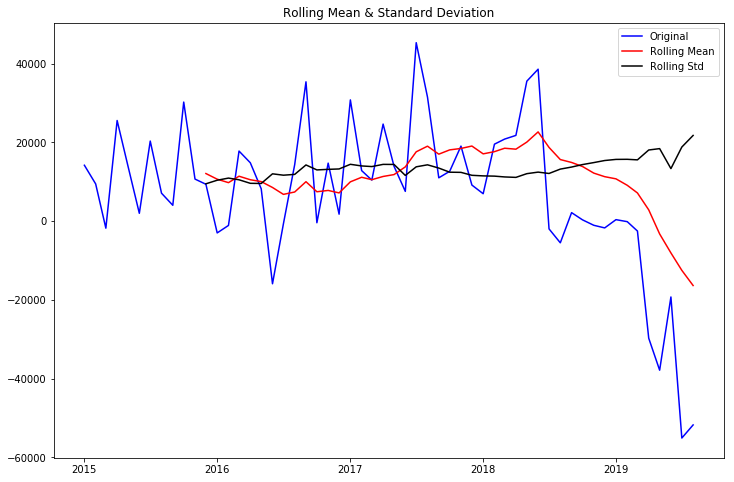

Results of Dickey-Fuller Test:
Test Statistic                  0.279509
p-value                         0.976385
#Lags Used                      3.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [61]:
#Prediction based on leading lag of 1 month
y=monthly['TotalSales(Domestic+Export)']
monthly['one-diff']=y-y.shift(12)
test_stationarity(monthly['one-diff'].iloc[12:-1])
# print(set(y.index) ^ set(monthly['one-diff'].iloc[:-1].index))

In [79]:
#Getting the statistics to see the working of Algorithm
result = adfuller(monthly['TotalSales(Domestic+Export)'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.581071
p-value: 0.493095


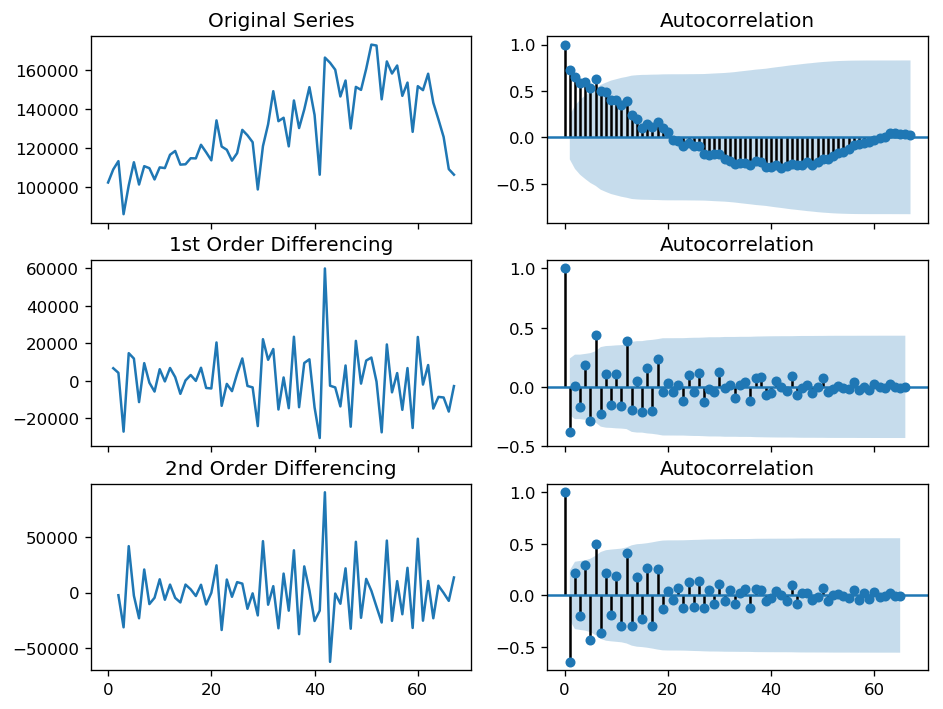

In [40]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(monthly['Total Sales(Domestic+Export)'].dropna()); axes[0, 0].set_title('Original Series')
plot_acf(monthly['Total Sales(Domestic+Export)'].dropna(), ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(monthly['Total Sales(Domestic+Export)'].dropna().diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(monthly['Total Sales(Domestic+Export)'].dropna().diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(monthly['Total Sales(Domestic+Export)'].dropna().diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(monthly['Total Sales(Domestic+Export)'].dropna().diff().diff().dropna(), ax=axes[2, 1])


plt.show()

#Not Sure which order derivative to be chosen, Tradeoff between value and convergance, Brute Force method applied

C:\Users\PUSHKAR\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


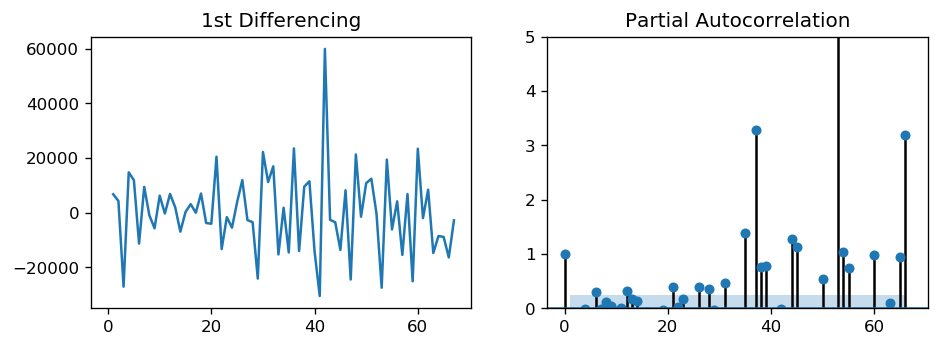

In [17]:
#Finding Partial Autocorrelation to see for first noticable change
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(monthly['Total Sales(Domestic+Export)'].dropna().diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(monthly['Total Sales(Domestic+Export)'].dropna().diff().dropna(), ax=axes[1])

plt.show()

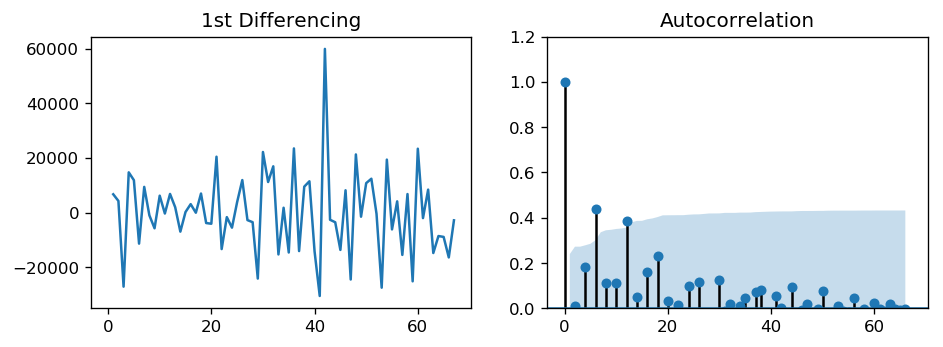

In [18]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(monthly['Total Sales(Domestic+Export)'].dropna().diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(monthly['Total Sales(Domestic+Export)'].dropna().diff().dropna(), ax=axes[1])

plt.show()

In [76]:
#Statistics of ARIMA Model, The p-value should be les than 0.05 if the model is working well. 
#It informs about the relatability of prediction factor to predicted value
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(monthly['TotalSales(Domestic+Export)'].dropna(), order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\PUSHKAR\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\PUSHKAR\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


                                   ARMA Model Results                                  
Dep. Variable:     TotalSales(Domestic+Export)   No. Observations:                   68
Model:                              ARMA(1, 1)   Log Likelihood                -741.616
Method:                                css-mle   S.D. of innovations          13071.444
Date:                         Sat, 07 Sep 2019   AIC                           1491.232
Time:                                 04:34:24   BIC                           1500.110
Sample:                             01-01-2014   HQIC                          1494.749
                                  - 08-01-2019                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                              1.231e+05   1.24e+04      9.913      0.000    9.87e+04   

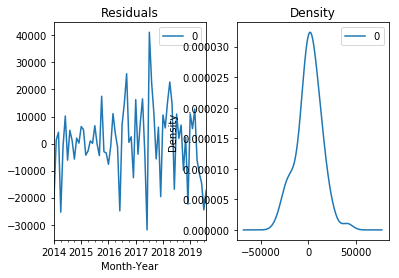

In [77]:
#Checking the impact of prediction, The density of residuals should be destributed around 0
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

C:\Users\PUSHKAR\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\PUSHKAR\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


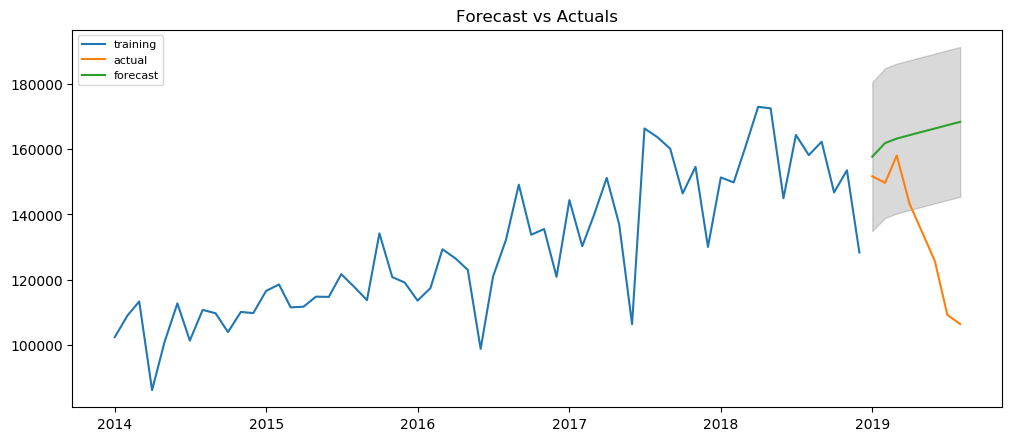

In [70]:
# Create Training and Test
# Forecasting
train = monthly['TotalSales(Domestic+Export)'].dropna()[:-8]
test = monthly['TotalSales(Domestic+Export)'].dropna()[-8:]
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(8, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

C:\Users\PUSHKAR\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\PUSHKAR\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\PUSHKAR\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


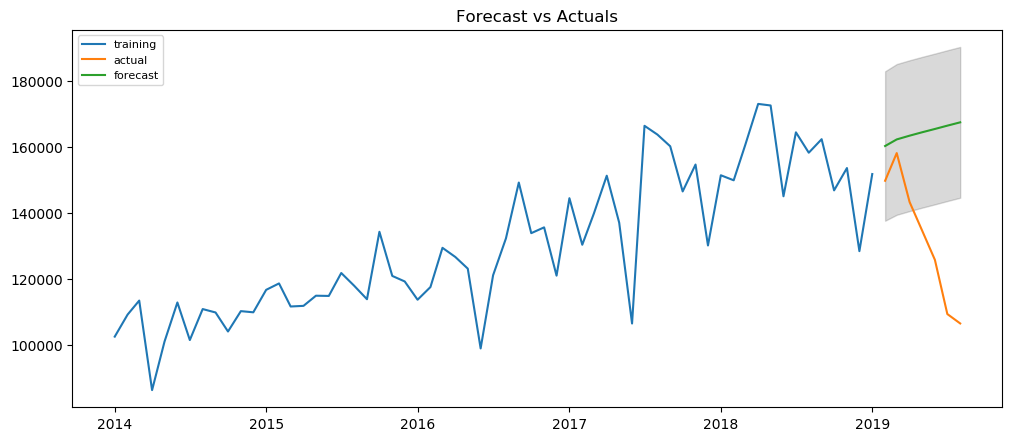

In [72]:
k=7
train = monthly['TotalSales(Domestic+Export)'].dropna()[:-1*k]
test = monthly['TotalSales(Domestic+Export)'].dropna()[-1*k:]
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(k, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

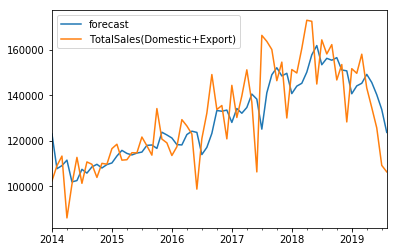

In [80]:
#Forecasting model with manual learning, Adjusted Forecast
model_fit.plot_predict(dynamic=False)
plt.show()